# Initial Imports

In [75]:
import sqlite3
import pandas as pd

# Loading the SQL file

In [76]:
# Created connection.
database_path = r"database.sqlite"

conn = sqlite3.connect(database_path)

# Creating Object of all table into the SQL file

In [77]:
# Creating dataframes from the tbales

df_country = pd.read_sql_query("SELECT * FROM country", conn)
df_league = pd.read_sql_query("SELECT * FROM league", conn)
df_match = pd.read_sql_query("SELECT * FROM match", conn)
df_player = pd.read_sql_query("SELECT * FROM player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM player_attributes", conn)
df_team = pd.read_sql_query("SELECT * FROM team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM team_attributes", conn)
df_sqlite_sequence = pd.read_sql_query("SELECT * FROM sqlite_sequence", conn)


**Deleting duplicate values**

In [78]:
# Deleting Duplicate values from the table

df_country = df_country.drop_duplicates()
df_league = df_league.drop_duplicates()
df_match = df_match.drop_duplicates()
df_player = df_player.drop_duplicates()
df_player_attributes = df_player_attributes.drop_duplicates()
df_team = df_team.drop_duplicates()
df_team_attributes = df_team_attributes.drop_duplicates()
df_sqlite_sequence = df_sqlite_sequence.drop_duplicates()

# Marging all table into one table Section 

In [79]:
# Concate all the tables in one
# Note: removed and merged by analyzed the all table relationship by zeel. so, before making change make sure to communicate with zeel

# Merging Country Table and League Table

In [80]:
# merging country table
df_merged_all_table = pd.merge(left=df_league, right=df_country, how='outer', left_on='country_id', right_on='id')
df_merged_all_table = df_merged_all_table.drop(["id_x", "country_id"], axis=1)
df_merged_all_table.columns.values[0] = "league_name"
df_merged_all_table.columns.values[1] = "league_id"
df_merged_all_table.columns.values[2] = "country_name"

In [81]:
df_merged_all_table

,league_name,league_id,country_name
0,Belgium Jupiler League,1,Belgium
1,England Premier League,1729,England
2,France Ligue 1,4769,France
3,Germany 1. Bundesliga,7809,Germany
4,Italy Serie A,10257,Italy
5,Netherlands Eredivisie,13274,Netherlands
6,Poland Ekstraklasa,15722,Poland
7,Portugal Liga ZON Sagres,17642,Portugal
8,Scotland Premier League,19694,Scotland
9,Spain LIGA BBVA,21518,Spain


# Merging match Table and previous combined Table

In [82]:
# merging league table
df_merged_all_table = df_match.merge(df_merged_all_table, how='outer', left_on='league_id', right_on='league_id')
df_merged_all_table = df_merged_all_table.drop(["league_id", "country_id"], axis=1)
df_merged_all_table.columns.values[0] = "match_id" 
df_merged_all_table = df_merged_all_table.drop(["match_id"], axis=1)

# Merging team Table and team attribute Table

In [83]:
# merging team table and team_attribute table with latest records of team
df_team_attributes = pd.read_sql_query("select * from Team_Attributes group by team_api_id order by max(date) DESC", conn)

df_merged_team_table = pd.merge(left=df_team, right=df_team_attributes, how='outer', left_on=['team_api_id'], right_on=['team_api_id'])

In [84]:
df_merged_team_table = df_merged_team_table.drop(columns=["id_x", "team_fifa_api_id_x", "id_y", "team_fifa_api_id_y"])

* performing imputation

In [85]:
# removed class columns 
skip_count = 0
for i in df_merged_team_table.columns:
    if df_merged_team_table[i].dtype == "object":
        skip_count += 1
        if skip_count > 3:
            df_merged_team_table = df_merged_team_table.drop(columns=i)

In [86]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

In [87]:
# getting team overall score based on mean
col_list = []
skip_count = 0
for i in df_merged_team_table.columns:
    skip_count += 1
    if skip_count > 4:
        col_list.append(i)

imputed_table = imputer.fit_transform(df_merged_team_table[col_list])

imputed_table = pd.DataFrame(imputed_table)
imputed_table = imputed_table.mean(axis = 1, skipna = False)

df_merged_team_table = df_merged_team_table.drop(columns=col_list)
df_merged_team_table = df_merged_team_table.drop(columns="date")
df_merged_team_table["team_overall_score"] = imputed_table

* imputation done and joined the imputed table with main team table

In [88]:
df_merged_team_table

,team_api_id,team_long_name,team_short_name,team_overall_score
0,9987,KRC Genk,GEN,51.777778
1,9993,Beerschot AC,BAC,49.000000
2,10000,SV Zulte-Waregem,ZUL,46.333333
3,9994,Sporting Lokeren,LOK,51.333333
4,9984,KSV Cercle Brugge,CEB,51.666667
...,...,...,...,...
294,10190,FC St. Gallen,GAL,43.222222
295,10191,FC Thun,THU,51.444444
296,9777,Servette FC,SER,50.333333
297,7730,FC Lausanne-Sports,LAU,50.000000


# Merging combined previous table with combined team table

* combine both the table and removed extra coulms 

In [89]:
# merging merged team table
df_merged_all_table = df_merged_all_table.merge(df_merged_team_table, how='outer', left_on=['home_team_api_id'], right_on=['team_api_id'])
df_merged_all_table.columns.values[2] = "date" 
df_merged_all_table = df_merged_all_table.merge(df_merged_team_table, how='outer', left_on=['away_team_api_id'], right_on=['team_api_id'])
df_merged_all_table.columns.values[2] = "date" 

for i in range(4):
    df_merged_all_table = df_merged_all_table.drop([df_merged_all_table.columns[-1]], axis=1)

for i in range(4):
    df_merged_all_table.columns.values[-1 - i] = df_merged_all_table.columns[-1 - i].split("_x")[0]

In [90]:
df_merged_all_table.columns

Index(['season', 'stage', 'date', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal',
       'home_player_X1', 'home_player_X2',
       ...
       'GBA', 'BSH', 'BSD', 'BSA', 'league_name', 'country_name',
       'team_api_id', 'team_long_name', 'team_short_name',
       'team_overall_score'],
      dtype='object', length=118)

# Merging player attribute table with player table

In [91]:
# merging team table and team_attribute table with latest records of team
df_player_attributes = pd.read_sql_query("select * from Player_Attributes group by Player_api_id order by max(date) DESC", conn)

# merging player_attribute table with player table
df_merged_player_table = pd.merge(left=df_player, right=df_player_attributes, how='outer', left_on=['player_api_id'], right_on=['player_api_id'])
df_merged_player_table = df_merged_player_table.drop(["id_x", "id_y", "player_fifa_api_id_y"], axis=1)
df_merged_player_table.columns.values[2] = "player_fifa_api_id" 
df_merged_player_table = df_merged_player_table.drop(columns="player_fifa_api_id") 

df_merged_player_table = df_merged_player_table.drop_duplicates() 

In [92]:
df_merged_player_table = df_merged_player_table.drop(columns=["date", "birthday"])

In [93]:
df_merged_player_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 0 to 11059
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_api_id        11060 non-null  int64  
 1   player_name          11060 non-null  object 
 2   height               11060 non-null  float64
 3   weight               11060 non-null  int64  
 4   overall_rating       11060 non-null  int64  
 5   potential            11060 non-null  int64  
 6   preferred_foot       11060 non-null  object 
 7   attacking_work_rate  10520 non-null  object 
 8   defensive_work_rate  11060 non-null  object 
 9   crossing             11060 non-null  int64  
 10  finishing            11060 non-null  int64  
 11  heading_accuracy     11060 non-null  int64  
 12  short_passing        11060 non-null  int64  
 13  volleys              10582 non-null  float64
 14  dribbling            11060 non-null  int64  
 15  curve                10582 non-null 

* To decide which column should we need to take and whoch columns need to impute

In [94]:
df_merged_player_table.isnull().sum()

player_api_id            0
player_name              0
height                   0
weight                   0
overall_rating           0
potential                0
preferred_foot           0
attacking_work_rate    540
defensive_work_rate      0
crossing                 0
finishing                0
heading_accuracy         0
short_passing            0
volleys                478
dribbling                0
curve                  478
free_kick_accuracy       0
long_passing             0
ball_control             0
acceleration             0
sprint_speed             0
agility                478
reactions                0
balance                478
shot_power               0
jumping                478
stamina                  0
strength                 0
long_shots               0
aggression               0
interceptions            0
positioning              0
vision                 478
penalties                0
marking                  0
standing_tackle          0
sliding_tackle         478
g

In [95]:
df_merged_player_table = df_merged_player_table.drop(columns=["preferred_foot", "attacking_work_rate", "defensive_work_rate"])

* implementing imputatuon to reduce the shape of the table

In [96]:
imputer = KNNImputer(n_neighbors=2)

In [97]:
# getting team overall score based on mean
col_list = []
skip_count = 0
for i in df_merged_player_table.columns:
    skip_count += 1
    if skip_count > 5:
        col_list.append(i)

imputed_table = imputer.fit_transform(df_merged_player_table[col_list])

imputed_table = pd.DataFrame(imputed_table)
imputed_table = imputed_table.mean(axis = 1, skipna = False)

df_merged_player_table = df_merged_player_table.drop(columns=col_list)
df_merged_player_table["player_overall_score"] = imputed_table

In [98]:
df_merged_player_table

,player_api_id,player_name,height,weight,overall_rating,player_overall_score
0,505942,Aaron Appindangoye,182.88,187,67,49.852941
1,155782,Aaron Cresswell,170.18,146,74,61.000000
2,162549,Aaron Doran,170.18,163,65,53.794118
3,30572,Aaron Galindo,182.88,198,69,48.029412
4,23780,Aaron Hughes,182.88,154,70,46.264706
...,...,...,...,...,...,...
11055,26357,Zoumana Camara,182.88,168,73,50.647059
11056,111182,Zsolt Laczko,182.88,176,63,51.441176
11057,36491,Zsolt Low,180.34,154,68,55.000000
11058,35506,Zurab Khizanishvili,185.42,172,67,50.294118


* converting player's weight and height into player_body_rate for idead player body rate

In [99]:
def calculate_ideal_player_body_rate(weight, height):

    # Sample formula: Ideal Body Rate = Weight / Height^2 (need to analyse the effective formula)
    ideal_body_rate = weight / (height/100) ** 2
    return ideal_body_rate

In [100]:
df_merged_player_table['player_ideal_body_rate'] = df_merged_player_table.apply(lambda row: calculate_ideal_player_body_rate(row['weight'], row['height']), axis=1)

In [101]:
df_merged_player_table = df_merged_player_table.drop(columns=["height", "weight"])

In [102]:
df_merged_player_table

,player_api_id,player_name,overall_rating,player_overall_score,player_ideal_body_rate
0,505942,Aaron Appindangoye,67,49.852941,55.912535
1,155782,Aaron Cresswell,74,61.000000,50.412219
2,162549,Aaron Doran,65,53.794118,56.282135
3,30572,Aaron Galindo,69,48.029412,59.201507
4,23780,Aaron Hughes,70,46.264706,46.045617
...,...,...,...,...,...
11055,26357,Zoumana Camara,73,50.647059,50.231582
11056,111182,Zsolt Laczko,63,51.441176,52.623562
11057,36491,Zsolt Low,68,55.000000,47.351811
11058,35506,Zurab Khizanishvili,67,50.294118,50.028248


# Adding new feature Player overall rating into match table

In [103]:
df_merged_all_table.drop_duplicates(inplace=True)

In [104]:
# combining total goal of a respected team

home_total_goal = pd.read_sql_query("select home_team_api_id, sum(home_team_goal) as home_total_goal from match group by home_team_api_id", conn)
away_total_goal = pd.read_sql_query("select away_team_api_id, sum(away_team_goal) as away_total_goal from match group by away_team_api_id", conn)

In [105]:
# merging both the home and away total goal to the match table

df_merged_all_table = pd.merge(df_merged_all_table, home_total_goal, on='home_team_api_id')
df_merged_all_table = pd.merge(df_merged_all_table, away_total_goal, on='away_team_api_id')

In [106]:
df_merged_player_table.head()

,player_api_id,player_name,overall_rating,player_overall_score,player_ideal_body_rate
0,505942,Aaron Appindangoye,67,49.852941,55.912535
1,155782,Aaron Cresswell,74,61.000000,50.412219
2,162549,Aaron Doran,65,53.794118,56.282135
3,30572,Aaron Galindo,69,48.029412,59.201507
4,23780,Aaron Hughes,70,46.264706,46.045617


* This section was implimented before the df_merged_player_table now dont need this so i commented it

In [107]:
# getting overall rating of player

# player_overall_rating = pd.read_sql_query("select * from (select player_api_id , max(overall_rating) as overall_rating from Player_Attributes group by player_api_id) as p where p.overall_rating is not null", conn)


In [108]:
# player_overall_rating

* combining player overall rating value to match table with home and away player

In [109]:
# for i in range(1,12):
#     df_merged_all_table = df_merged_all_table.merge(player_overall_rating, how='left', left_on='home_player_' + str(i), right_on='player_api_id')
#     df_merged_all_table = df_merged_all_table.drop(['home_player_' + str(i), "player_api_id"], axis=1)
#     df_merged_all_table.columns.values[-1] = 'home_player_' + str(i) 

# for i in range(1,12):
#     df_merged_all_table = df_merged_all_table.merge(player_overall_rating, how='left', left_on='away_player_' + str(i), right_on='player_api_id')
#     df_merged_all_table = df_merged_all_table.drop(['away_player_' + str(i), "player_api_id"], axis=1)
#     df_merged_all_table.columns.values[-1] = 'away_player_' + str(i) 

# df_merged_all_table = df_merged_all_table.drop([], axis=1)

In [110]:
# temp_list = "season stage date home_team_api_id away_team_api_id home_player_X1 home_player_X2 home_player_X3 home_player_X4 home_player_X5 home_player_X6 home_player_X7 home_player_X8 home_player_X9 home_player_X10 home_player_X11 away_player_X1 away_player_X2 away_player_X3 away_player_X4 away_player_X5 away_player_X6 away_player_X7 away_player_X8 away_player_X9 away_player_X10 away_player_X11 home_player_Y1 home_player_Y2 home_player_Y3 home_player_Y4 home_player_Y5 home_player_Y6 home_player_Y7 home_player_Y8 home_player_Y9 home_player_Y10 home_player_Y11 away_player_Y1 away_player_Y2 away_player_Y3 away_player_Y4 away_player_Y5 away_player_Y6 away_player_Y7 away_player_Y8 away_player_Y9 away_player_Y10 away_player_Y11".split(" ")
temp_list = "season stage date home_player_X1 home_player_X2 home_player_X3 home_player_X4 home_player_X5 home_player_X6 home_player_X7 home_player_X8 home_player_X9 home_player_X10 home_player_X11 away_player_X1 away_player_X2 away_player_X3 away_player_X4 away_player_X5 away_player_X6 away_player_X7 away_player_X8 away_player_X9 away_player_X10 away_player_X11 home_player_Y1 home_player_Y2 home_player_Y3 home_player_Y4 home_player_Y5 home_player_Y6 home_player_Y7 home_player_Y8 home_player_Y9 home_player_Y10 home_player_Y11 away_player_Y1 away_player_Y2 away_player_Y3 away_player_Y4 away_player_Y5 away_player_Y6 away_player_Y7 away_player_Y8 away_player_Y9 away_player_Y10 away_player_Y11".split(" ")

In [111]:
temp_list

['season',
 'stage',
 'date',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player_Y11']

In [112]:
df_merged_all_table.columns

Index(['season', 'stage', 'date', 'match_api_id', 'home_team_api_id',
       'away_team_api_id', 'home_team_goal', 'away_team_goal',
       'home_player_X1', 'home_player_X2',
       ...
       'BSD', 'BSA', 'league_name', 'country_name', 'team_api_id',
       'team_long_name', 'team_short_name', 'team_overall_score',
       'home_total_goal', 'away_total_goal'],
      dtype='object', length=120)

In [113]:
df_merged_all_table = df_merged_all_table.drop(columns= temp_list)

In [114]:
df_merged_all_table.columns

Index(['match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
       'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA',
       'BSH', 'BSD', 'BSA', 'league_name', 'country_name', 'team_api_id',
       'team_long_name', 'team_short_name', 'team_overall_score',
       'home_total_goal', 'away_to

<style>
/* Define CSS styles for attribute descriptions */
.attribute-description {
  font-weight: bold;
  color: #1E90FF;
}

.description {
  margin-bottom: 10px;
  font-size: 14px;
  line-height: 1.6;
}

.application-title {
  margin-top: 20px;
  font-weight: bold;
  color: #228B22;
}

.application {
  margin-bottom: 10px;
  font-size: 14px;
  line-height: 1.6;
}
</style>

<h1 style="color: #1E90FF;">Attributes Descriptions</h1>

<div class="attribute-description">1. 'goal'</div>
<div class="description">The 'goal' attribute represents the number of goals scored in the match by each team.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute is crucial for analyzing the goal-scoring capabilities of teams and identifying high-scoring matches.</div>

<div class="attribute-description">2. 'shoton'</div>
<div class="description">The 'shoton' attribute indicates the number of shots on target attempted by each team.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute helps in assessing the attacking strength of teams and their accuracy in converting shots into goals.</div>

<div class="attribute-description">3. 'shotoff'</div>
<div class="description">The 'shotoff' attribute denotes the number of shots off target attempted by each team.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute provides insights into the teams' shooting proficiency and their ability to keep shots on target.</div>



<div class="attribute-description">4. 'foulcommit'</div>
<div class="description">The 'foulcommit' attribute represents the number of fouls committed by each team.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute is valuable for analyzing the aggressiveness and discipline of teams during a match.</div>



<div class="attribute-description">5. 'card'</div>
<div class="description">The 'card' attribute indicates the number of cards (yellow and red) shown to players of each team.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute helps in studying the disciplinary record of teams and identifying players with a higher likelihood of receiving cards.</div>



<div class="attribute-description">6. 'cross'</div>
<div class="description">The 'cross' attribute denotes the number of crosses attempted by each team.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute is useful for analyzing teams' playing style and their reliance on crossing to create goal-scoring opportunities.</div>



<div class="attribute-description">7. 'corner'</div>
<div class="description">The 'corner' attribute represents the number of corner kicks awarded to each team.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute provides insights into teams' ability to create goal-scoring chances from corner kicks.</div>



<div class="attribute-description">8. 'possession'</div>
<div class="description">The 'possession' attribute indicates the percentage of time each team had possession of the ball during the match.</div>

<div class="application-title">Application:</div>
<div class="application">This attribute is crucial for understanding teams' playing patterns, ball control, and dominance in the game.</div>



<div class="attribute-description">9. 'B365H', 'B365D', 'B365A'</div>
<div class="description">These attributes are odds provided by the bookmaker Bet365 for Home Win, Draw, and Away Win, respectively.</div>

<div class="application-title">Application:</div>
<div class="application">These attributes are relevant for betting analysis, allowing data scientists to study the bookmakers' predictions and potential outcomes.</div>



<div class="attribute-description">10. 'BWH', 'BWD', 'BWA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">Similar to the Bet365 odds, these attributes can be used for betting analysis and comparing different bookmakers' predictions.</div>



<div class="attribute-description">11. 'IWH', 'IWD', 'IWA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">These odds, like the previous ones, help in betting analysis and comparing bookmakers' predictions.</div>



<div class="attribute-description">12. 'LBH', 'LBD', 'LBA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">Useful for betting analysis and understanding the variations in odds among different bookmakers.</div>



<div class="attribute-description">13. 'PSH', 'PSD', 'PSA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">These odds are relevant for betting analysis and comparing bookmakers' predictions.</div>


<div class="attribute-description">14. 'WHH', 'WHD', 'WHA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">Useful for betting analysis and comparing different bookmakers' predictions.</div>



<div class="attribute-description">15. 'SJH', 'SJD', 'SJA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">These odds are relevant for betting analysis and comparing bookmakers' predictions.</div>



<div class="attribute-description">16. 'VCH', 'VCD', 'VCA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">Useful for betting analysis and comparing different bookmakers' predictions.</div>



<div class="attribute-description">17. 'GBH', 'GBD', 'GBA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">These odds are relevant for betting analysis and comparing bookmakers' predictions.</div>



<div class="attribute-description">18. 'BSH', 'BSD', 'BSA'</div>
<div class="description">Odds for Home Win, Draw, and Away Win from another bookmaker.</div>

<div class="application-title">Application:</div>
<div class="application">Useful for betting analysis and comparing different bookmakers' predictions.</div>





<style>
/* Define CSS styles for the definition */

.definition {
  margin-bottom: 10px;
  font-size: 14px;
  line-height: 1.6;
}
</style>



<div class="definition"><b>Bookmaker</b>: A bookmaker is a person or organization that sets and offers odds on various events, including sports events like football matches. They create a market for betting and determine the odds for each possible outcome of an event.</div>



# Merging player merged table with main merged table

In [115]:
for i in range(1,12):
    df_merged_all_table = df_merged_all_table.merge(df_merged_player_table, how='left', left_on=['home_player_' + str(i)], right_on=['player_api_id'])
    df_merged_all_table = df_merged_all_table.drop(['home_player_' + str(i), "player_api_id", "player_name"], axis=1)
    df_merged_all_table.columns.values[-1] = 'home_player_' + str(i) + "_ideal_body_rate"
    df_merged_all_table.columns.values[-2] = 'home_player_' + str(i) + "_overall_score"
    df_merged_all_table.columns.values[-3] = 'home_player_' + str(i) + "_overall_rating"

for i in range(1,12):
    df_merged_all_table = df_merged_all_table.merge(df_merged_player_table, how='left', left_on=['away_player_' + str(i)], right_on=['player_api_id'])
    df_merged_all_table = df_merged_all_table.drop(['away_player_' + str(i), "player_api_id", "player_name"], axis=1)
    df_merged_all_table.columns.values[-1] = 'away_player_' + str(i) + "_ideal_body_rate"
    df_merged_all_table.columns.values[-2] = 'away_player_' + str(i) + "_overall_score"
    df_merged_all_table.columns.values[-3] = 'away_player_' + str(i) + "_overall_rating"



In [116]:
df_merged_all_table.columns

Index(['match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'goal', 'shoton', 'shotoff',
       'foulcommit', 'card',
       ...
       'away_player_8_ideal_body_rate', 'away_player_9_overall_rating',
       'away_player_9_overall_score', 'away_player_9_ideal_body_rate',
       'away_player_10_overall_rating', 'away_player_10_overall_score',
       'away_player_10_ideal_body_rate', 'away_player_11_overall_rating',
       'away_player_11_overall_score', 'away_player_11_ideal_body_rate'],
      dtype='object', length=117)

* performing imputation

* note:- need to take opinion of all group memeber on this imputation

In [117]:
# import the KNNimputer class
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

In [118]:
# getting player table based on mean
col_list = []
skip_count = 0
for i in df_merged_all_table.columns:
    skip_count += 1
    if skip_count > 51:
        col_list.append(i)

imputed_table = imputer.fit_transform(df_merged_all_table[col_list])

imputed_table = pd.DataFrame(imputed_table)

home_players_avg_overall_rating = imputed_table[[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]].mean(axis=1)
home_players_avg_overall_score = imputed_table[[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31]].mean(axis=1)
home_players_avg_ideal_body_rate = imputed_table[[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 33]].mean(axis=1)

away_players_avg_overall_rating = imputed_table[[34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 63]].mean(axis=1)
away_players_avg_overall_score = imputed_table[[35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 64]].mean(axis=1)
away_players_avg_ideal_body_rate = imputed_table[[36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 65]].mean(axis=1)

df_merged_all_table = df_merged_all_table.drop(columns=col_list)

df_merged_all_table["home_players_avg_overall_rating"] = home_players_avg_overall_rating
df_merged_all_table["home_players_avg_overall_score"] = home_players_avg_overall_score
df_merged_all_table["home_players_avg_ideal_body_rate"] = home_players_avg_ideal_body_rate
df_merged_all_table["away_players_avg_overall_rating"] = away_players_avg_overall_rating
df_merged_all_table["away_players_avg_overall_score"] = away_players_avg_overall_score
df_merged_all_table["away_players_avg_ideal_body_rate"] = away_players_avg_ideal_body_rate

In [119]:
df_merged_all_table.shape

(25979, 57)

# Adding new feature Team formation using player's position *

In [120]:
import matplotlib.pyplot as plt
from collections import Counter
from math import isnan

In [121]:
def team_formation(df_match):    
    formation_list=list()

    for n in range(len(df_match)):
        
        match=df_match.iloc[n]
        
        home_players_api_id = list()
        away_players_api_id = list()
        home_players_x = list()
        away_players_x = list()
        home_players_y = list()
        away_players_y = list()

        for i in range(1,12):
            home_players_api_id.append(match['home_player_%d' % i])
            away_players_api_id.append(match['away_player_%d' % i])
            home_players_x.append(match['home_player_X%d' % i])
            away_players_x.append(match['away_player_X%d' % i])
            home_players_y.append(match['home_player_Y%d' % i])
            away_players_y.append(match['away_player_Y%d' % i])

        #Fetch players'names 
        players_api_id = [home_players_api_id,away_players_api_id]
        # print(players_api_id)
        players_api_id.append(home_players_api_id) # Home
        players_api_id.append(away_players_api_id) # Away
        players_names = [[None]*11,[None]*11]

        cur = conn.cursor()

        for i in range(2):
            players_api_id_not_none = [x for x in players_api_id[i] if isnan(x)==False]
            request = 'SELECT player_api_id,player_name FROM Player'
            request += ' WHERE player_api_id IN (' + ','.join(map(str, players_api_id_not_none)) + ')'
            cur.execute(request)
            players = cur.fetchall()
            for player in players:
                # print(players_api_id[i].index(player['player_api_id']))
                # print(player)
                idx = players_api_id[i].index(int(player[0]))
                name = player[1].split()[-1] # keep only the last name
                players_names[i][idx] = name


        home_players_x = [5 if x==1 else x for x in home_players_x]
        away_players_x = [5 if x==1 else x for x in away_players_x]

        away_players_y=[(element-12)/1.7 for element in away_players_y]
        home_players_y=[(-element+12)/1.7 for element in home_players_y]
    
    
        players_y = [home_players_y,away_players_y]
        formations = [None] * 2
        for i in range(2):
                
            formation_dict=Counter(players_y[i]);
            if i==0:
                sorted_keys = sorted(formation_dict,reverse=True)
            else:
                sorted_keys = sorted(formation_dict) 

            formation = ''
            for key in sorted_keys[1:-1]:
                y = formation_dict[key]
                formation += '%d-' % y
            formation += '%d' % formation_dict[sorted_keys[-1]]   
            formations[i] = formation


        formation_list.append(formations[0])
        formation_list.append(formations[1])

        #print('Home team formation: ' + formations[0])
        #print('Away team formation: ' + formations[1])

    return formation_list


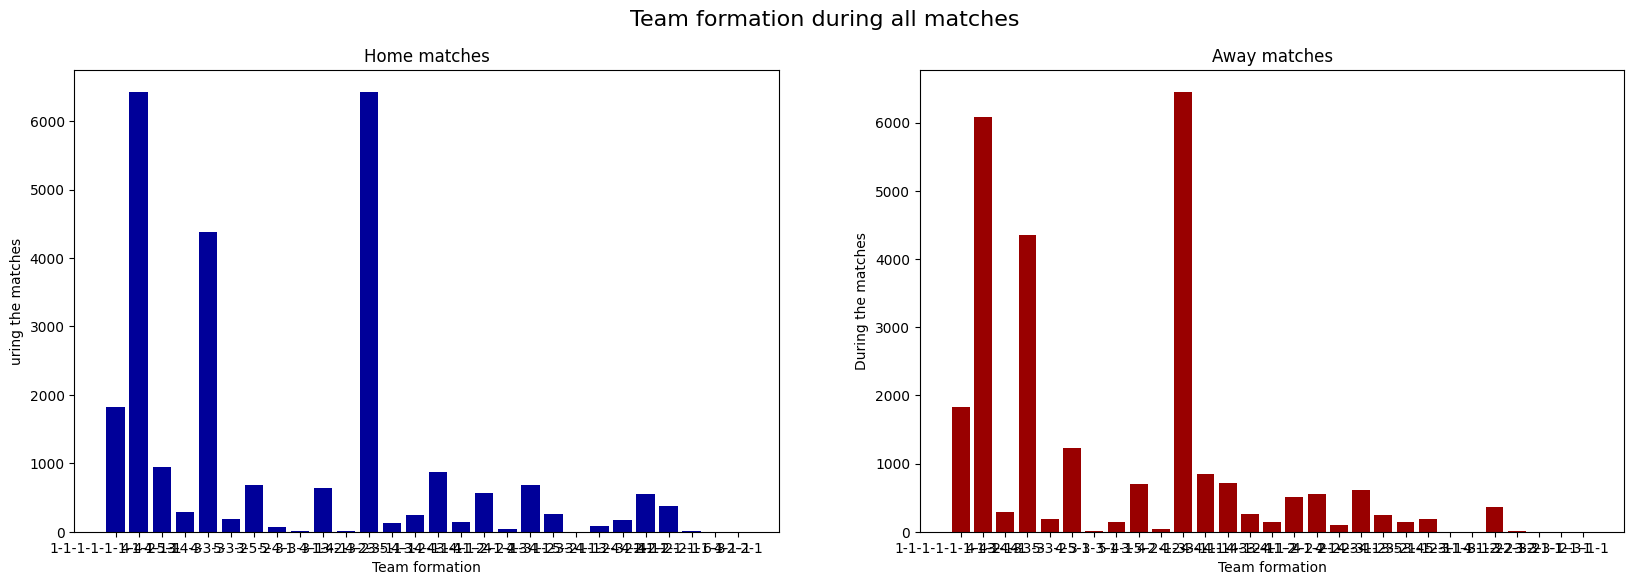

In [122]:
formation=team_formation(df_match)   
home_team_formation = formation[::2]
away_team_formation = formation[1::2]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))

ax1.bar(Counter(home_team_formation).keys(), Counter(home_team_formation).values(), color=(0,0,0.6))
ax2.bar(Counter(away_team_formation).keys(), Counter(away_team_formation).values(), color=(0.6,0,0))

ax1.set_ylabel('uring the matches')
ax1.set_xlabel('Team formation')
ax1.set_title('Home matches')

ax2.set_ylabel('During the matches')
ax2.set_xlabel('Team formation')
ax2.set_title('Away matches')

fig.suptitle('Team formation during all matches', fontsize=16)

plt.show()

In [123]:
# printing all the unique team formation in all the matcheds
print(len(list(set(home_team_formation))))
print(len(list(set(away_team_formation))))

28
29


# Adding total number of win, loss, draw matches for both home and away teams

In [124]:
home_team_result = pd.read_sql_query("select home_team_api_id, count(case when home_team_goal > away_team_goal then 'win' end) as home_total_win, count(case when home_team_goal < away_team_goal then 'loose' end) as home_total_loose, count(case when home_team_goal = away_team_goal then 'draw' end) as home_total_draw from match group by home_team_api_id", conn)
away_team_result = pd.read_sql_query("select away_team_api_id, count(case when away_team_goal > home_team_goal then 'win' end) as away_total_win, count(case when away_team_goal < home_team_goal then 'loose' end) as away_total_loose, count(case when away_team_goal = home_team_goal then 'draw' end) as away_total_draw from match group by away_team_api_id", conn)

In [125]:
home_team_result

,home_team_api_id,home_total_win,home_total_loose,home_total_draw
0,1601,54,38,28
1,1773,16,16,13
2,1957,63,30,27
3,2033,19,29,27
4,2182,74,19,27
...,...,...,...,...
294,158085,18,20,11
295,177361,5,6,4
296,188163,3,10,4
297,208931,6,8,5


In [126]:
away_team_result

,away_team_api_id,away_total_win,away_total_loose,away_total_draw
0,1601,38,53,29
1,1773,6,24,15
2,1957,24,59,37
3,2033,13,34,28
4,2182,50,37,33
...,...,...,...,...
294,158085,10,21,18
295,177361,3,7,5
296,188163,5,10,2
297,208931,3,10,6


In [127]:
df_merged_all_table.shape

(25979, 57)

In [128]:
df_merged_all_table = df_merged_all_table.merge(home_team_result, how='left', left_on=['home_team_api_id'], right_on=['home_team_api_id'])
df_merged_all_table = df_merged_all_table.merge(away_team_result, how='left', left_on=['away_team_api_id'], right_on=['away_team_api_id'])

In [129]:
df_merged_all_table.shape

(25979, 63)

In [130]:
df_merged_all_table = df_merged_all_table.drop(columns=["home_team_api_id", "away_team_api_id"])

In [131]:
df_merged_all_table.columns

Index(['match_api_id', 'home_team_goal', 'away_team_goal', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'league_name', 'country_name', 'team_api_id', 'team_long_name',
       'team_short_name', 'team_overall_score', 'home_total_goal',
       'away_total_goal', 'home_players_avg_overall_rating',
       'home_players_avg_overall_score', 'home_players_avg_ideal_body_rate',
       'away_players_avg_overall_rating', 'away_players_avg_overall_score',
       'away_players_avg_ideal_body_rate', 'home_total_win',
       'home_total_loose', 'home_total_draw', 'away_total_win',
       'away_total_loose', 'away_total_draw'],
      dtype='object')

# Adding total number of win, loss, draw league wise for both home and away teams

In [132]:
league_home_team_result = pd.read_sql_query("select l.name, count(case when home_team_goal > away_team_goal then 'win' end) as league_home_total_win, count(case when home_team_goal < away_team_goal then 'loose' end) as league_home_total_loose, count(case when home_team_goal = away_team_goal then 'draw' end) as league_home_total_draw from match left join League l where l.id = league_id group by league_id", conn)
league_away_team_result = pd.read_sql_query("select l.name, count(case when away_team_goal > home_team_goal then 'win' end) as league_away_total_win, count(case when away_team_goal < home_team_goal then 'loose' end) as league_away_total_loose, count(case when away_team_goal = home_team_goal then 'draw' end) as league_away_total_draw from match left join League l where l.id = league_id group by league_id", conn)

In [133]:
league_home_team_result

,name,league_home_total_win,league_home_total_loose,league_home_total_draw
0,Belgium Jupiler League,810,493,425
1,England Premier League,1390,867,783
2,France Ligue 1,1359,822,859
3,Germany 1. Bundesliga,1107,744,597
4,Italy Serie A,1407,814,796
5,Netherlands Eredivisie,1171,696,581
6,Poland Ekstraklasa,870,525,525
7,Portugal Liga ZON Sagres,908,611,533
8,Scotland Premier League,760,617,447
9,Spain LIGA BBVA,1485,851,704


In [134]:
league_away_team_result

,name,league_away_total_win,league_away_total_loose,league_away_total_draw
0,Belgium Jupiler League,493,810,425
1,England Premier League,867,1390,783
2,France Ligue 1,822,1359,859
3,Germany 1. Bundesliga,744,1107,597
4,Italy Serie A,814,1407,796
5,Netherlands Eredivisie,696,1171,581
6,Poland Ekstraklasa,525,870,525
7,Portugal Liga ZON Sagres,611,908,533
8,Scotland Premier League,617,760,447
9,Spain LIGA BBVA,851,1485,704


In [135]:
df_merged_all_table.shape

(25979, 61)

In [136]:
df_merged_all_table = df_merged_all_table.merge(league_home_team_result, how='left', left_on=['league_name'], right_on=['name'])
df_merged_all_table = df_merged_all_table.merge(league_away_team_result, how='left', left_on=['league_name'], right_on=['name'])

In [137]:
df_merged_all_table.shape

(25979, 69)

In [138]:
df_merged_all_table = df_merged_all_table.drop(columns=["name_x", "name_y"])

In [139]:
df_merged_all_table.columns

Index(['match_api_id', 'home_team_goal', 'away_team_goal', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'league_name', 'country_name', 'team_api_id', 'team_long_name',
       'team_short_name', 'team_overall_score', 'home_total_goal',
       'away_total_goal', 'home_players_avg_overall_rating',
       'home_players_avg_overall_score', 'home_players_avg_ideal_body_rate',
       'away_players_avg_overall_rating', 'away_players_avg_overall_score',
       'away_players_avg_ideal_body_rate', 'home_total_win',
       'home_total_loose', 'home_total_draw', 'away_total_win',
       'away_total_loose', 'away_total_draw', 'league_home_total_win',
       'league_home_total_loose', 'league_home_total_draw',
     

In [140]:
df_merged_all_table.shape

(25979, 67)

# Reaming work

In [141]:
# print(df_match.shape)
# print(df_match["goal"].isnull().sum(), end=" missing values\n")
# print(df_match["shoton"].isnull().sum(), end=" missing values\n")
# print(df_match["shotoff"].isnull().sum(), end=" missing values\n")
# print(df_match["foulcommit"].isnull().sum(), end=" missing values\n")
# print(df_match["card"].isnull().sum(), end=" missing values\n")
# print(df_match["cross"].isnull().sum(), end=" missing values\n")
# print(df_match["corner"].isnull().sum(), end=" missing values\n")
# print(df_match["possession"].isnull().sum(), end=" missing values\n")
# print(df_match["foulcommit"].isnull().sum(), end=" missing value\ns")
# print(df_match["B365H"].isnull().sum(), end=" missing values\n")
# print(df_match["B365D"].isnull().sum(), end=" missing values\n")
# print(df_match["B365A"].isnull().sum(), end=" missing values\n")
# print(df_match["BWH"].isnull().sum(), end=" missing values\n")
# print(df_match["BWD"].isnull().sum(), end=" missing values\n")
# print(df_match["BWA"].isnull().sum(), end=" missing values\n")
# print(df_match["IWH"].isnull().sum(), end=" missing values\n")
# print(df_match["IWD"].isnull().sum(), end=" missing values\n")
# print(df_match["LBH"].isnull().sum(), end=" missing values\n")
# print(df_match["IWD"].isnull().sum(), end=" missing values\n")
# print(df_match["LBH"].isnull().sum(), end=" missing values\n")
# print(df_match["LBD"].isnull().sum(), end=" missing values\n")
# print(df_match["LBA"].isnull().sum(), end=" missing values\n")
# print(df_match["PSH"].isnull().sum(), end=" missing values\n")
# print(df_match["PSD"].isnull().sum(), end=" missing values\n")
# print(df_match["PSA"].isnull().sum(), end=" missing values\n")
# print(df_match["WHH"].isnull().sum(), end=" missing values\n")
# print(df_match["WHD"].isnull().sum(), end=" missing values\n")
# print(df_match["WHA"].isnull().sum(), end=" missing values\n")
# print(df_match["SJH"].isnull().sum(), end=" missing values\n")
# print(df_match["SJD"].isnull().sum(), end=" missing values\n")
# print(df_match["SJA"].isnull().sum(), end=" missing values\n")
# print(df_match["VCH"].isnull().sum(), end=" missing values\n")
# print(df_match["VCD"].isnull().sum(), end=" missing values\n")
# print(df_match["VCA"].isnull().sum(), end=" missing values\n")
# print(df_match["GBH"].isnull().sum(), end=" missing values\n")
# print(df_match["GBD"].isnull().sum(), end=" missing values\n")
# print(df_match["GBA"].isnull().sum(), end=" missing values\n")
# print(df_match["BSH"].isnull().sum(), end=" missing values\n")
# print(df_match["BSD"].isnull().sum(), end=" missing values\n")
# print(df_match["BSA"].isnull().sum(), end=" missing values\n")

# Generating Target Variable

In [142]:
# generating target variable
def get_match_label(match):
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
    #Identify match label
    if home_goals > away_goals:
        return "HomeWin"
    elif home_goals == away_goals:
        return "Draw"
    elif home_goals < away_goals:
        return "AwayWin"

df_merged_all_table['target'] = df_merged_all_table.apply(get_match_label, axis=1)

In [143]:
# droping columns with contains id (Converting n3 form to n1 form)
df_merged_all_table = df_merged_all_table.drop(['home_team_goal',
       'away_team_goal'], axis=1)

df_merged_all_table.columns

Index(['match_api_id', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card',
       'cross', 'corner', 'possession', 'B365H', 'B365D', 'B365A', 'BWH',
       'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD',
       'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA',
       'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA', 'league_name', 'country_name',
       'team_api_id', 'team_long_name', 'team_short_name',
       'team_overall_score', 'home_total_goal', 'away_total_goal',
       'home_players_avg_overall_rating', 'home_players_avg_overall_score',
       'home_players_avg_ideal_body_rate', 'away_players_avg_overall_rating',
       'away_players_avg_overall_score', 'away_players_avg_ideal_body_rate',
       'home_total_win', 'home_total_loose', 'home_total_draw',
       'away_total_win', 'away_total_loose', 'away_total_draw',
       'league_home_total_win', 'league_home_total_loose',
       'league_home_total_draw', 'league_away_total_win',
       'league_a

# Converting dataframe into pickle file for modeling

In [149]:
df_merged_all_table.shape

(25979, 66)

In [144]:
# Converting dataframe into pickle for modeling

# df_merged_all_table.to_pickle('merged_all_table' + ".pkl", compression="bz2")
# df_merged_all_table.to_csv( 'merged_all_table.csv',index=False)

In [148]:
# # to check that pickle file is relaible
# df = pd.read_pickle("merged_all_table.pkl", compression='bz2')

# df.shape

(25979, 66)